# `rioxarray`

`rioxarray`:

- is a python extension for `xarray` to manipuate `xarray.DataArray's` as rasters
- means *raster input/output + xarray*

## Data 

Raster files from the US National Agriculture Imagery Program (NAIP)
- high resolution images from 2020 with four spectral bands : Red, Green, Blue, and Near-infrared (NIR)
- data is pre-processed into two rasters (RBG and NIR)


## Import .tif

In [33]:
import os # to worth with file paths
import numpy as np
import matplotlib.pyplot as plt 

import rioxarray as rioxr
import xarray as xr 

import geopandas as gpd
from shapely.geometry import Polygon

There are multiple ways of opening a .tif file using `xarray` or `rioxarray`.

Use `rioxarray.open_rasterio()` function to open the `tif` file

In [2]:
# make file path
nir_fp = os.path.join(os.getcwd(),'data','nir.tif')

nir = rioxr.open_rasterio(nir_fp)
# get current working directory
#os.getcwd()

nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)>
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## `xr.DataArray` exploration

Let's verify we loaded an `xarray.DataArray`

In [3]:
type(nir)

xarray.core.dataarray.DataArray

In [4]:
# access some attributes
print('shape', nir.shape)
print('data type:', nir.dtype)

shape (1, 3208, 2419)
data type: uint8


In [5]:
# check values of array at the corners
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

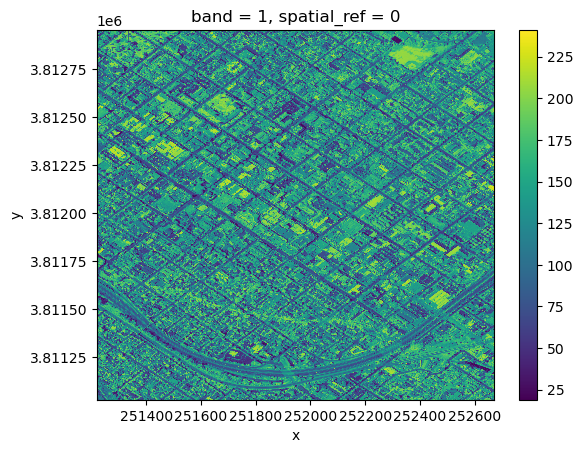

In [6]:
# exploratory plot
nir.plot()

## `rio` accessor

An *accessor* in Python lets us access a different set of properties from an object.
Use the `.rio` accessor for `xarray.DataArray` to access its raster properties.

Example

In [7]:
print('# bands:' ,nir.rio.count)
print('height:', nir.rio.height)
print('width:', nir.rio.width)
print('resolution :', nir.rio.resolution())
print('no data values:', nir.rio.nodata, '\n')

print('spatial bounding box:')
print(nir.rio.bounds(), '\n')
print('CRS:', nir.rio.crs)

# bands: 1
height: 3208
width: 2419
resolution : (0.6000000000000072, -0.600000000000058)
no data values: None 

spatial bounding box:
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS: EPSG:26911


In [8]:
nir.rio.crs.is_projected

True

# Multiband raster

In [9]:
# open RGB raster
rgb_fp = os.path.join(os.getcwd(),'data','rgb.tif')
rgb = rioxr.open_rasterio(rgb_fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)>
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

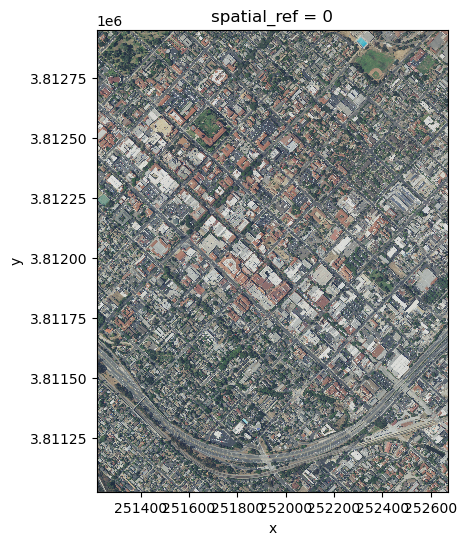

In [10]:
# parameters for plotting this raster
size = 6 # size of figure
aspect = rgb.rio.width / rgb.rio.height # ratio width/height

#plot three bands as RGB image 
rgb.plot.imshow(size = size, aspect = aspect)

## Box for clipping

Our area of interest (aoi) is a smaller region 

In [11]:
# list vertices of our aoi box 
points = [[-119.70608227128903, 34.426300194372274],
          [-119.70608227128903, 34.42041139020533],
          [-119.6967885126002, 34.42041139020533],
          [-119.6967885126002, 34.426300194372274],
          [-119.70608227128903, 34.426300194372274]]

#make a geodataframe with aoi
aoi = gpd.GeoDataFrame(geometry = [Polygon(points)],
                       crs = 'epsg:4326')
aoi

,geometry
0,"POLYGON ((-119.70608 34.42630, -119.70608 34.4..."


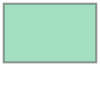

In [12]:
Polygon(points)

<AxesSubplot:>

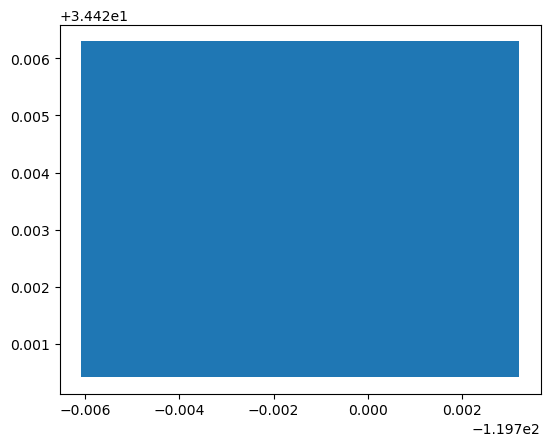

In [13]:
aoi.plot()

## Clip raster

Remember: **if two geospatial sets will interact, they need to be in the same CRS**
Check:

In [14]:
print('aoi:', aoi.crs)
print('nir:', nir.rio.crs)
print('rgb:',rgb.rio.crs)

aoi: epsg:4326
nir: EPSG:26911
rgb: EPSG:26911


In [15]:
#reproject aoi to rgb crs
aoi = aoi.to_crs(rgb.rio.crs)
print('matched crs? :' ,aoi.crs == rgb.rio.crs)

aoi.crs

matched crs? : True


<Bound CRS: PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM ...>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from NAD83 to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: NAD83 / UTM zone 11N

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x', ylabel='y'>

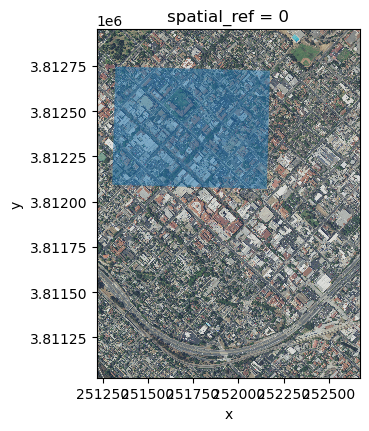

In [16]:
# plot aoi outline and RBG raster together
fig, ax = plt.subplots()
fig.set_size_inches((size, size*aspect)) #cannot use ax and size, aspect together
rgb.plot.imshow(ax = ax)
aoi.plot(ax = ax, alpha = 0.5)

To clip the raster using the aoi polygon, we use the `.rio.clip_box()` method

In [17]:
# clip rasters to aoi
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

In [18]:
print('original shape:', rgb.shape)
print('reduced shape:', rgb_small.shape)

original shape: (3, 3208, 2419)
reduced shape: (3, 1128, 1454)


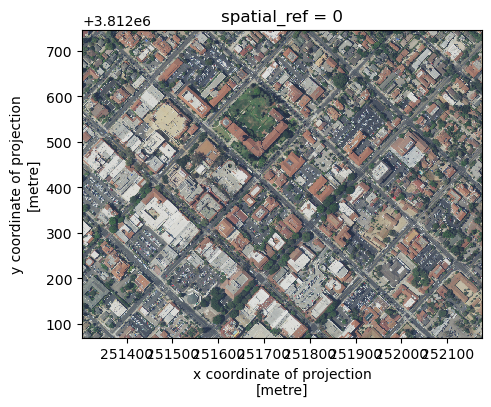

In [19]:
# plot it with correct ratio
size = 4 # height in inches
aspect = rgb_small.rio.width / rgb_small.rio.height

rgb_small.plot.imshow(size = size, aspect = aspect)

## Compute NDVI

NDVI = Normalized DIfference Vegetation Index.

We want to compute it over our aoi.

NDVI:
- index used to check if an rea has live green vegetation
- calculated using only the red and NIR bands
- formula: $$NDVI = (NIR- Red)/(NIR + Red)$$
- results range from -1 to 1 
- plants: always positive values from 0.2 and 1 

First, select the red band:

In [20]:
red = rgb_small.sel(band = 1)
red

<xarray.DataArray (y: 1128, x: 1454)>
[1640112 values with dtype=uint8]
Coordinates:
    band         int64 1
  * x            (x) float64 2.513e+05 2.513e+05 ... 2.522e+05 2.522e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

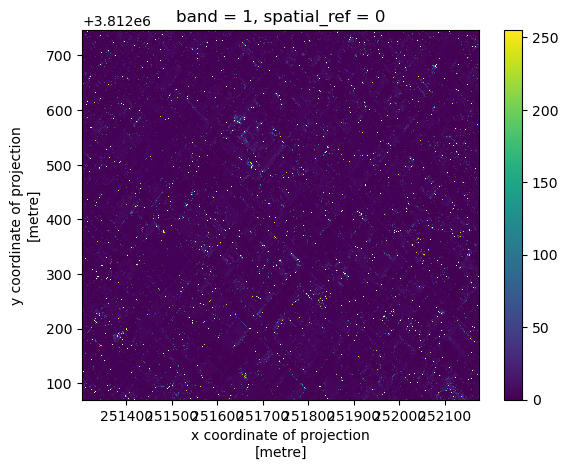

In [23]:
ndvi = (nir_small - red)/(nir_small + red)
ndvi.plot()

## What is happening?

Both NIR and red have `uint8` dtype.

`uint8` stands for 8-bit unsigned integer.
- very small data type that only holds integers from 0 up to 255

Calculations with `uint8` don't return what we are used to when working with integers.

In [24]:
np.uint8(150) + np.uint8(150)

/tmp/ipykernel_1501819/1890984988.py:1: RuntimeWarning: overflow encountered in ubyte_scalars
  np.uint8(150) + np.uint8(150)


44

In the NDVI formula we add NIR + Red. If both NIR and Red are very close to 255, when we add them, the calculation overflows the `uint8` dtype. 

Notice: when we performed the NDVI calculation, we did not get any warning.

This could be called an example of *failing silently * 

**important : check our results!!**

Solution: update dtype of rasters to `int16` which will be big enough to perform the calculation

In [25]:
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')
print('RED: original dtype', rgb_small.dtype, '.... new dtype:', red16.dtype)
print('NIR: original dtype', nir_small.dtype, '.... new dtype:', nir16.dtype)

RED: original dtype uint8 .... new dtype: int16
NIR: original dtype uint8 .... new dtype: int16


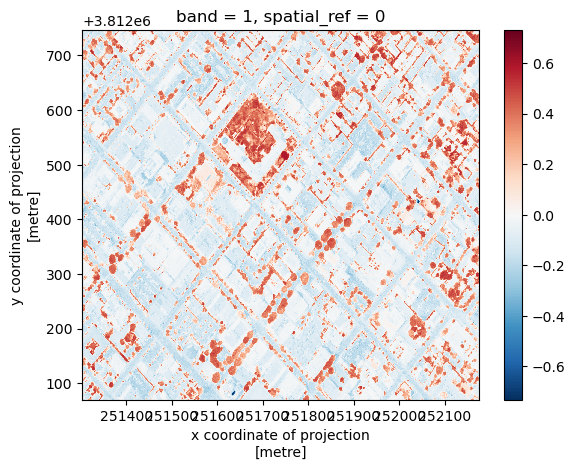

In [26]:
ndvi = (nir16 - red16)/(nir16 + red16)
ndvi.plot()

(array([2.30000e+01, 3.50000e+01, 2.10000e+01, 2.40000e+01, 8.00000e+00,
        9.00000e+00, 8.00000e+00, 9.00000e+00, 1.10000e+01, 8.00000e+00,
        1.80000e+01, 2.10000e+01, 3.50000e+01, 4.50000e+01, 1.12000e+02,
        3.54000e+02, 1.20600e+03, 3.82700e+03, 1.14860e+04, 3.45280e+04,
        8.45990e+04, 1.33849e+05, 1.44668e+05, 1.90669e+05, 1.89321e+05,
        1.95422e+05, 1.90192e+05, 5.26850e+04, 3.15670e+04, 2.63280e+04,
        2.11800e+04, 1.93740e+04, 1.89890e+04, 1.90850e+04, 2.00730e+04,
        2.17470e+04, 2.32530e+04, 2.49870e+04, 2.68750e+04, 2.77900e+04,
        2.85880e+04, 2.78430e+04, 2.49310e+04, 1.97710e+04, 1.33730e+04,
        7.21300e+03, 2.69900e+03, 8.25000e+02, 3.66000e+02, 6.20000e+01]),
 array([-0.73056995, -0.70340794, -0.67624594, -0.64908393, -0.62192192,
        -0.59475992, -0.56759791, -0.5404359 , -0.5132739 , -0.48611189,
        -0.45894989, -0.43178788, -0.40462587, -0.37746387, -0.35030186,
        -0.32313985, -0.29597785, -0.26881584, -0

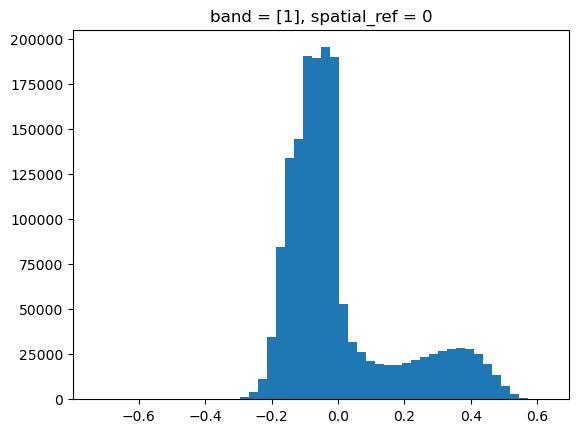

In [28]:
# making a histogram of the ndvi values

ndvi.plot.hist(bins = 50)

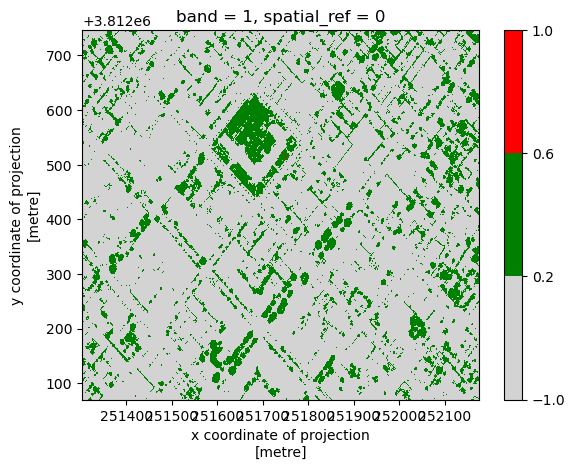

In [32]:
# -1 < NDVI <0.2 : no vegetation
# 0.2 <= NDVI < 0.6 for sparse vegetation
# 0.6 < NDVI < 1 for dense vegetation

class_bins= (-1,0.2,0.6,1)
colors = ('lightgray','green','red')
ndvi.plot(levels = class_bins, colors = colors)

In [34]:
ndvi_classes = xr.apply_ufunc(
        np.digitize,
        ndvi,
        class_bins
)
ndvi_classes

<xarray.DataArray (band: 1, y: 1128, x: 1454)>
array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 2, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [2, 1, 1, ..., 1, 1, 1]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.513e+05 2.513e+05 ... 2.522e+05 2.522e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0

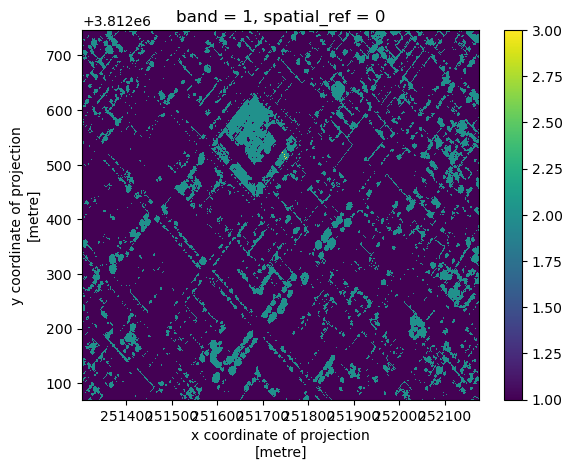

In [35]:
ndvi_classes.plot()